# Bike Rental Demand Analysis Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [2]:
# Import dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
submission = pd.read_csv("sampleSubmission.csv")
data = pd.concat([df_train, df_test], ignore_index = True)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [3]:
print(df_train.shape)
print(df_test.shape)
print(submission.shape)
print(data.shape)

(10886, 12)
(6493, 9)
(6493, 2)
(17379, 12)


## Feature Definition
- `datetime` : hourly date + timestamp  
- `season`:
    - 1 = spring,
    - 2 = summer,
    - 3 = fall,
    - 4 = winter
- `holiday`: whether the day is a holiday or not (1/0)
- `workingday`: whether the day is neither a weekend nor holiday (1/0)
- `weather`:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy (clear)
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (Mist)
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (Light)
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog temp - temperature in Celsius (heavy)
- `temp:` hourly temperature in Celsius
- `atemp`:  "feels like" temperature in Celsius
- `humidity`:  relative humidity
- `windspeed` : wind speed
- `casual` : number of non-registered user rentals initiated
- `registered` : number of registered user rentals initiated
- `count` : number of total rentals

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [5]:
# Summary of feature data
list_item = []
for col in data.columns:
    list_item.append([col, data[col].dtype, 
                      data[col].isna().sum(), 
                      round(100*data[col].isna().sum()/len(data[col]), 2), 
                      data[col].nunique(), 
                      data[col].unique()[:10]])

df_desc = pd.DataFrame(data=list_item, columns='feature, datatype, null_values, null_percentage, unique_values, unique_sample'.split(","))
df_desc
     

,feature,datatype,null_values,null_percentage,unique_values,unique_sample
0,datetime,object,0,0.00,17379,"[2011-01-01 00:00:00, 2011-01-01 01:00:00, 201..."
1,season,int64,0,0.00,4,"[1, 2, 3, 4]"
2,holiday,int64,0,0.00,2,"[0, 1]"
3,workingday,int64,0,0.00,2,"[0, 1]"
4,weather,int64,0,0.00,4,"[1, 2, 3, 4]"
5,temp,float64,0,0.00,50,"[9.84, 9.02, 8.2, 13.12, 15.58, 14.76, 17.22, ..."
6,atemp,float64,0,0.00,65,"[14.395, 13.635, 12.88, 17.425, 19.695, 16.665..."
7,humidity,int64,0,0.00,89,"[81, 80, 75, 86, 76, 77, 72, 82, 88, 87]"
8,windspeed,float64,0,0.00,30,"[0.0, 6.0032, 16.9979, 19.0012, 19.9995, 12.99..."
9,casual,float64,6493,37.36,309,"[3.0, 8.0, 5.0, 0.0, 2.0, 1.0, 12.0, 26.0, 29...."


In [6]:
data.duplicated().sum()

0

There are no duplicate data entries or null values present in the training dataset. The test dataset has null values because it does not have the 'registered,' 'casual,' and 'count' columns. Therefore, we can proceed with the next step of data preparation.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,17379.0,2.501640,1.106918,1.00,2.0000,3.000,3.0000,4.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.000,0.0000,1.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.000,1.0000,1.0000
weather,17379.0,1.425283,0.639357,1.00,1.0000,1.000,2.0000,4.0000
temp,17379.0,20.376474,7.894801,0.82,13.9400,20.500,27.0600,41.0000
atemp,17379.0,23.788755,8.592511,0.00,16.6650,24.240,31.0600,50.0000
humidity,17379.0,62.722884,19.292983,0.00,48.0000,63.000,78.0000,100.0000
windspeed,17379.0,12.736540,8.196795,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


## Data Preparation

In [8]:
df = data.copy()

df['datetime'] = pd.to_datetime(df['datetime'])
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["dayofweek"] = df["datetime"].dt.dayofweek
df["hour"] = df["datetime"].dt.hour
df['year_month'] = df['year'].astype(str) + '-0' + df['month'].astype(str)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,dayofweek,hour,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011,1,5,0,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011,1,5,1,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011,1,5,2,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011,1,5,3,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011,1,5,4,2011-01


In [9]:
df[['datetime', 'year',	'month', 'dayofweek', 'hour', 'year_month']].head(10)

,datetime,year,month,dayofweek,hour,year_month
0,2011-01-01 00:00:00,2011,1,5,0,2011-01
1,2011-01-01 01:00:00,2011,1,5,1,2011-01
2,2011-01-01 02:00:00,2011,1,5,2,2011-01
3,2011-01-01 03:00:00,2011,1,5,3,2011-01
4,2011-01-01 04:00:00,2011,1,5,4,2011-01
5,2011-01-01 05:00:00,2011,1,5,5,2011-01
6,2011-01-01 06:00:00,2011,1,5,6,2011-01
7,2011-01-01 07:00:00,2011,1,5,7,2011-01
8,2011-01-01 08:00:00,2011,1,5,8,2011-01
9,2011-01-01 09:00:00,2011,1,5,9,2011-01


In [10]:
df_eda = df.copy()
df_eda['season'] = df_eda['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})
df_eda['holiday'] = df_eda['holiday'].map({0:'Not holiday',1:'holiday'})
df_eda['workingday'] = df_eda['workingday'].map({0:'Not workingday',1:'workingday'})
df_eda['weather'] = df_eda['weather'].map({1:'Clear, Few clouds, Partly cloudy, Partly cloudy',
                                           2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                           3:'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                                           4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})
df_eda['dayofweek'] = df_eda['dayofweek'].map({0: 'Monday',
                                                1: 'Tuesday',
                                                2: 'Wednesday',
                                                3: 'Thursday',
                                                4: 'Friday',
                                                5: 'Saturday',
                                                6: 'Sunday'})

In [11]:
df_eda.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,dayofweek,hour,year_month
0,2011-01-01 00:00:00,spring,Not holiday,Not workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0.0,3.0,13.0,16.0,2011,1,Saturday,0,2011-01
1,2011-01-01 01:00:00,spring,Not holiday,Not workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0,8.0,32.0,40.0,2011,1,Saturday,1,2011-01
2,2011-01-01 02:00:00,spring,Not holiday,Not workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0,5.0,27.0,32.0,2011,1,Saturday,2,2011-01
3,2011-01-01 03:00:00,spring,Not holiday,Not workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0,3.0,10.0,13.0,2011,1,Saturday,3,2011-01
4,2011-01-01 04:00:00,spring,Not holiday,Not workingday,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0,0.0,1.0,1.0,2011,1,Saturday,4,2011-01


## Exploratory Data Analysis


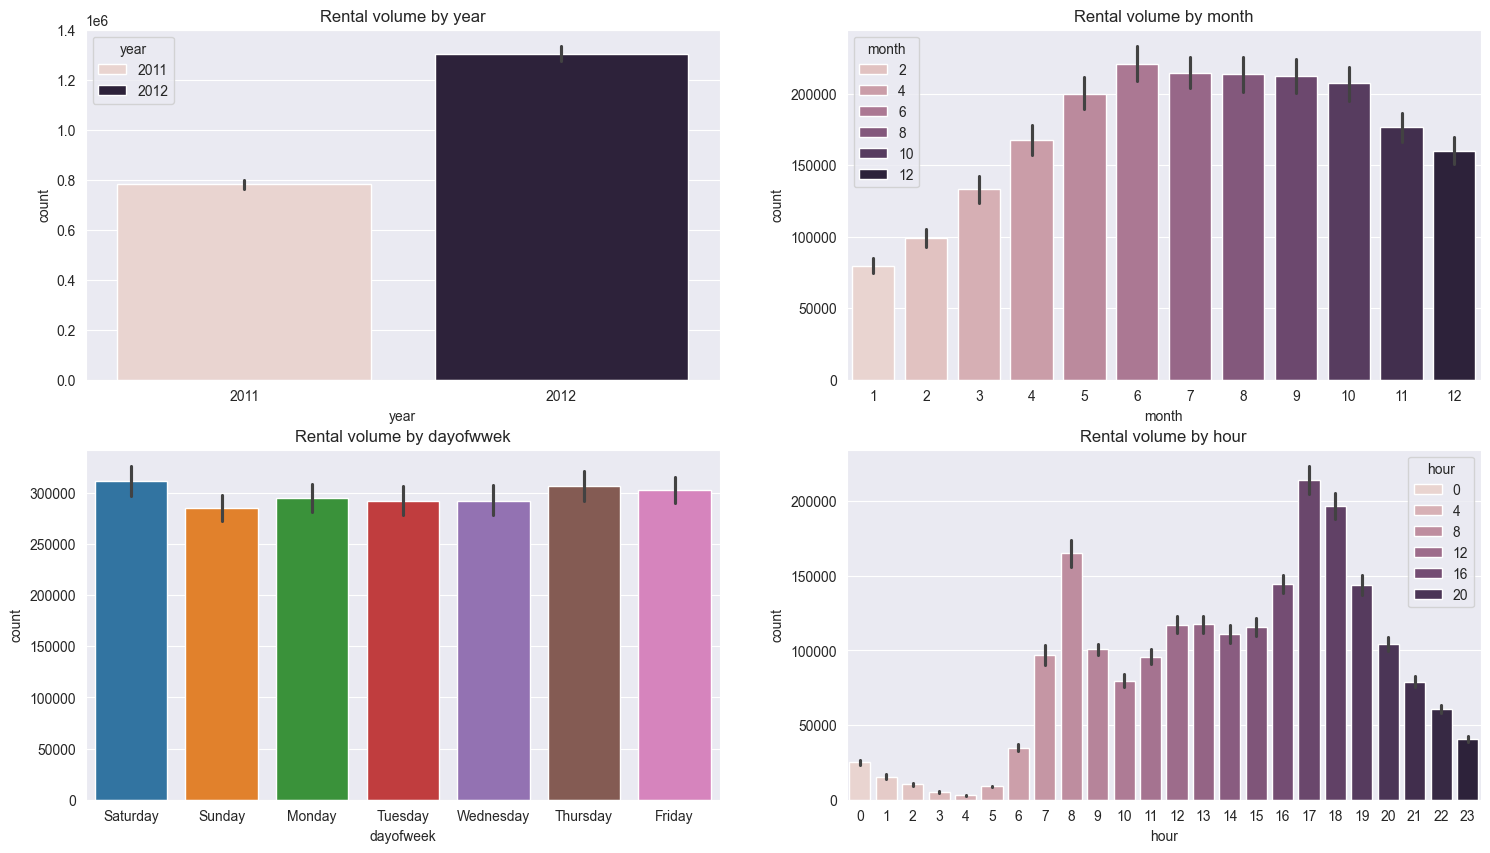

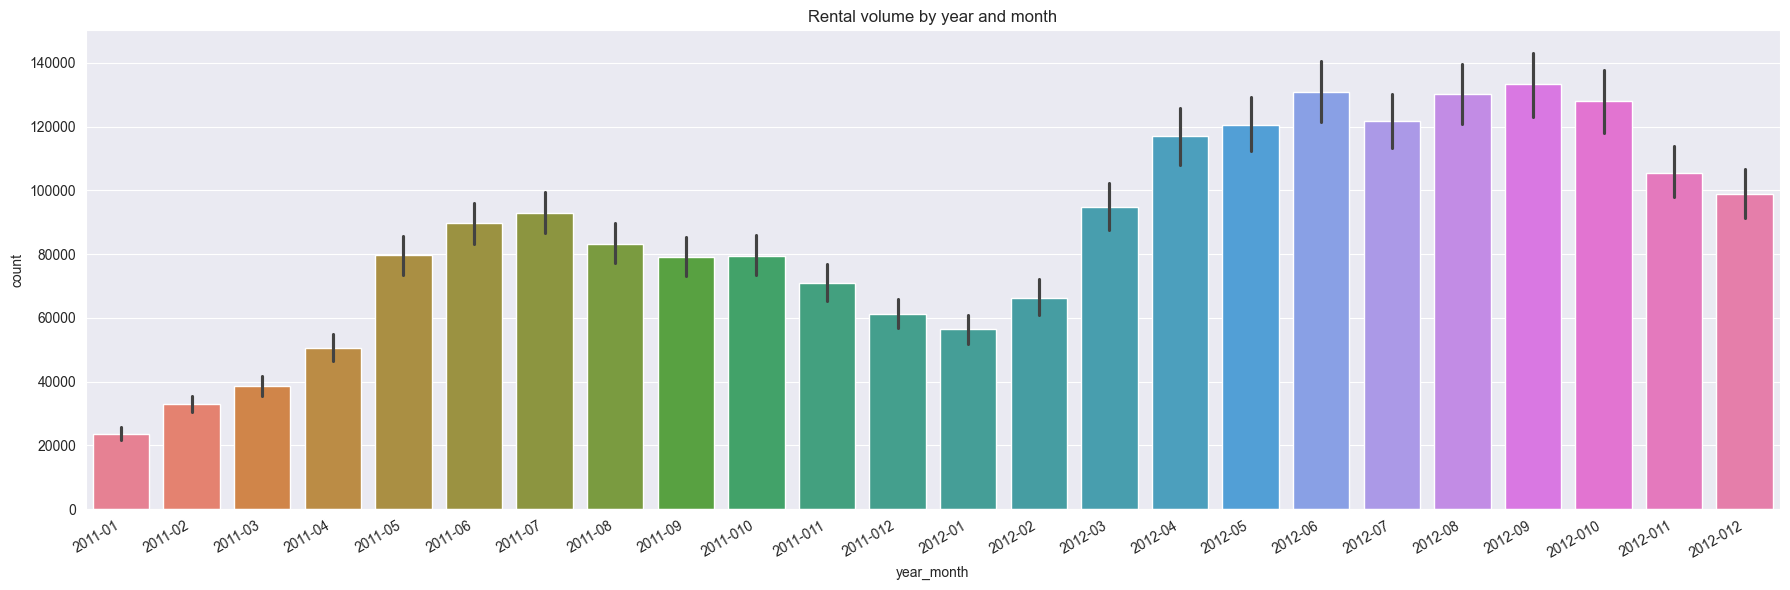

In [12]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)

sns.barplot(data=df_eda, x="year", y="count", hue="year", estimator=sum, ax=ax1)
sns.barplot(data=df_eda, x="month", y="count", hue="month", estimator=sum, ax=ax2)
sns.barplot(data=df_eda, x="dayofweek", y="count", hue="dayofweek", estimator=sum, ax=ax3)
sns.barplot(data=df_eda, x="hour", y="count", hue="hour", estimator=sum, ax=ax4)

ax1.set(title="Rental volume by year")
ax2.set(title="Rental volume by month")
ax3.set(title="Rental volume by dayofwwek")
ax4.set(title="Rental volume by hour")

fig, ax5 = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
sns.barplot(data=df, x="year_month", y="count", hue="year_month", estimator=sum, ax=ax5)
ax5.set_title("Rental volume by year and month")
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()


- In 2022, the rental volume was higher than the previous year. From January to June, the rental volume steadily increased and stabilized afterward until October. After October, the rental volume significantly decreased. Understanding that winter typically ends in February in Washington DC, it's reasonable to infer that people are more likely to use bicycles during warmer seasons. However, further analysis is needed to strengthen this insight.
- On Saturday, the rental volume is the highest, but it decreases significantly on Sunday, becoming the lowest rental volume of the week.
- We observed a clear trend in bike demand over hours.
  - `High demand:` 7-9 and 17-19 hours
  - `Average demand:` 10-16 hours
  - `Low demand:` 0-6 and 20-24 hours

[Text(0.5, 1.0, 'Rental volume by dayofweek')]

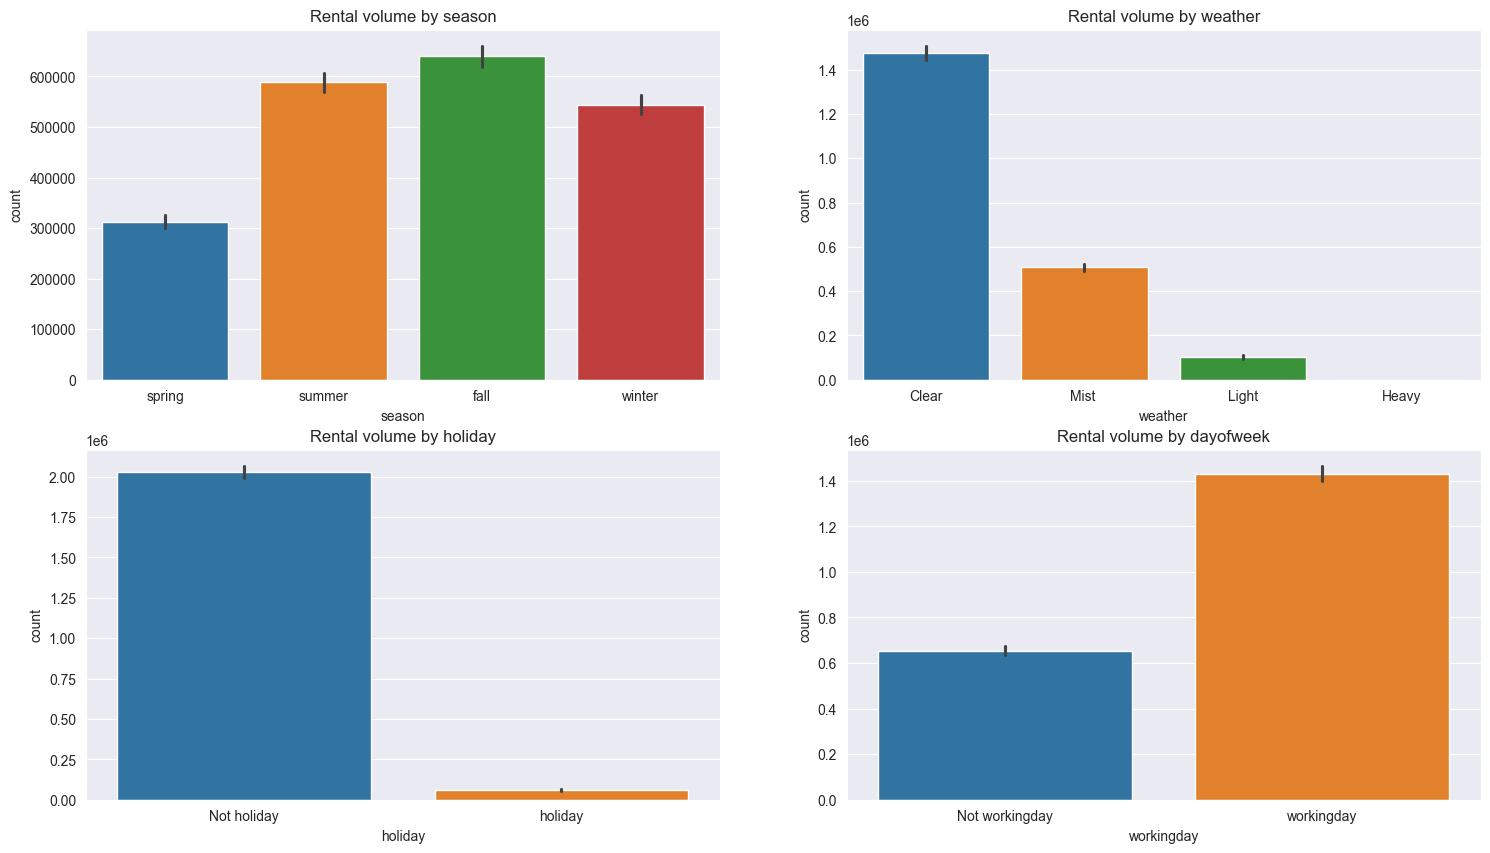

In [13]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18, 10)

sns.barplot(data=df_eda, x="season", y="count", hue="season", estimator=sum, ax=ax1)
sns.barplot(data=df_eda, x=df_eda['weather'].str[:5], y="count", hue=df_eda['weather'].str[:5],  estimator=sum, ax=ax2)
sns.barplot(data=df_eda, x="holiday", y="count", hue="holiday", estimator=sum,  ax=ax3)
sns.barplot(data=df_eda, x="workingday", y="count", hue="workingday",  estimator=sum, ax=ax4)

ax1.set(title="Rental volume by season")
ax2.set(title="Rental volume by weather")
ax3.set(title="Rental volume by holiday")
ax4.set(title="Rental volume by dayofweek")

- We observed that fall, followed by summer, is the peak season for bike usage. During winter (colder season), it's likely that fewer people consider biking due to the weather conditions. Conversely, spring exhibits a lower volume.
- it's evident that the best weather conditions for bike usage are clear weather. However, there are still some individuals who prefer biking in misty or overcast conditions. Furthermore, when considering weather conditions, 'light' indicates minimal precipitation such as light rain or snow, while 'heavy' denotes stronger precipitation. In heavy weather seasons, the preference for biking decreases significantly, with many individuals opting not to bike during such conditions.
- Most people tend to use bikes on weekdays rather than on holidays because they may use bikes as a daily means of transportation to work or school

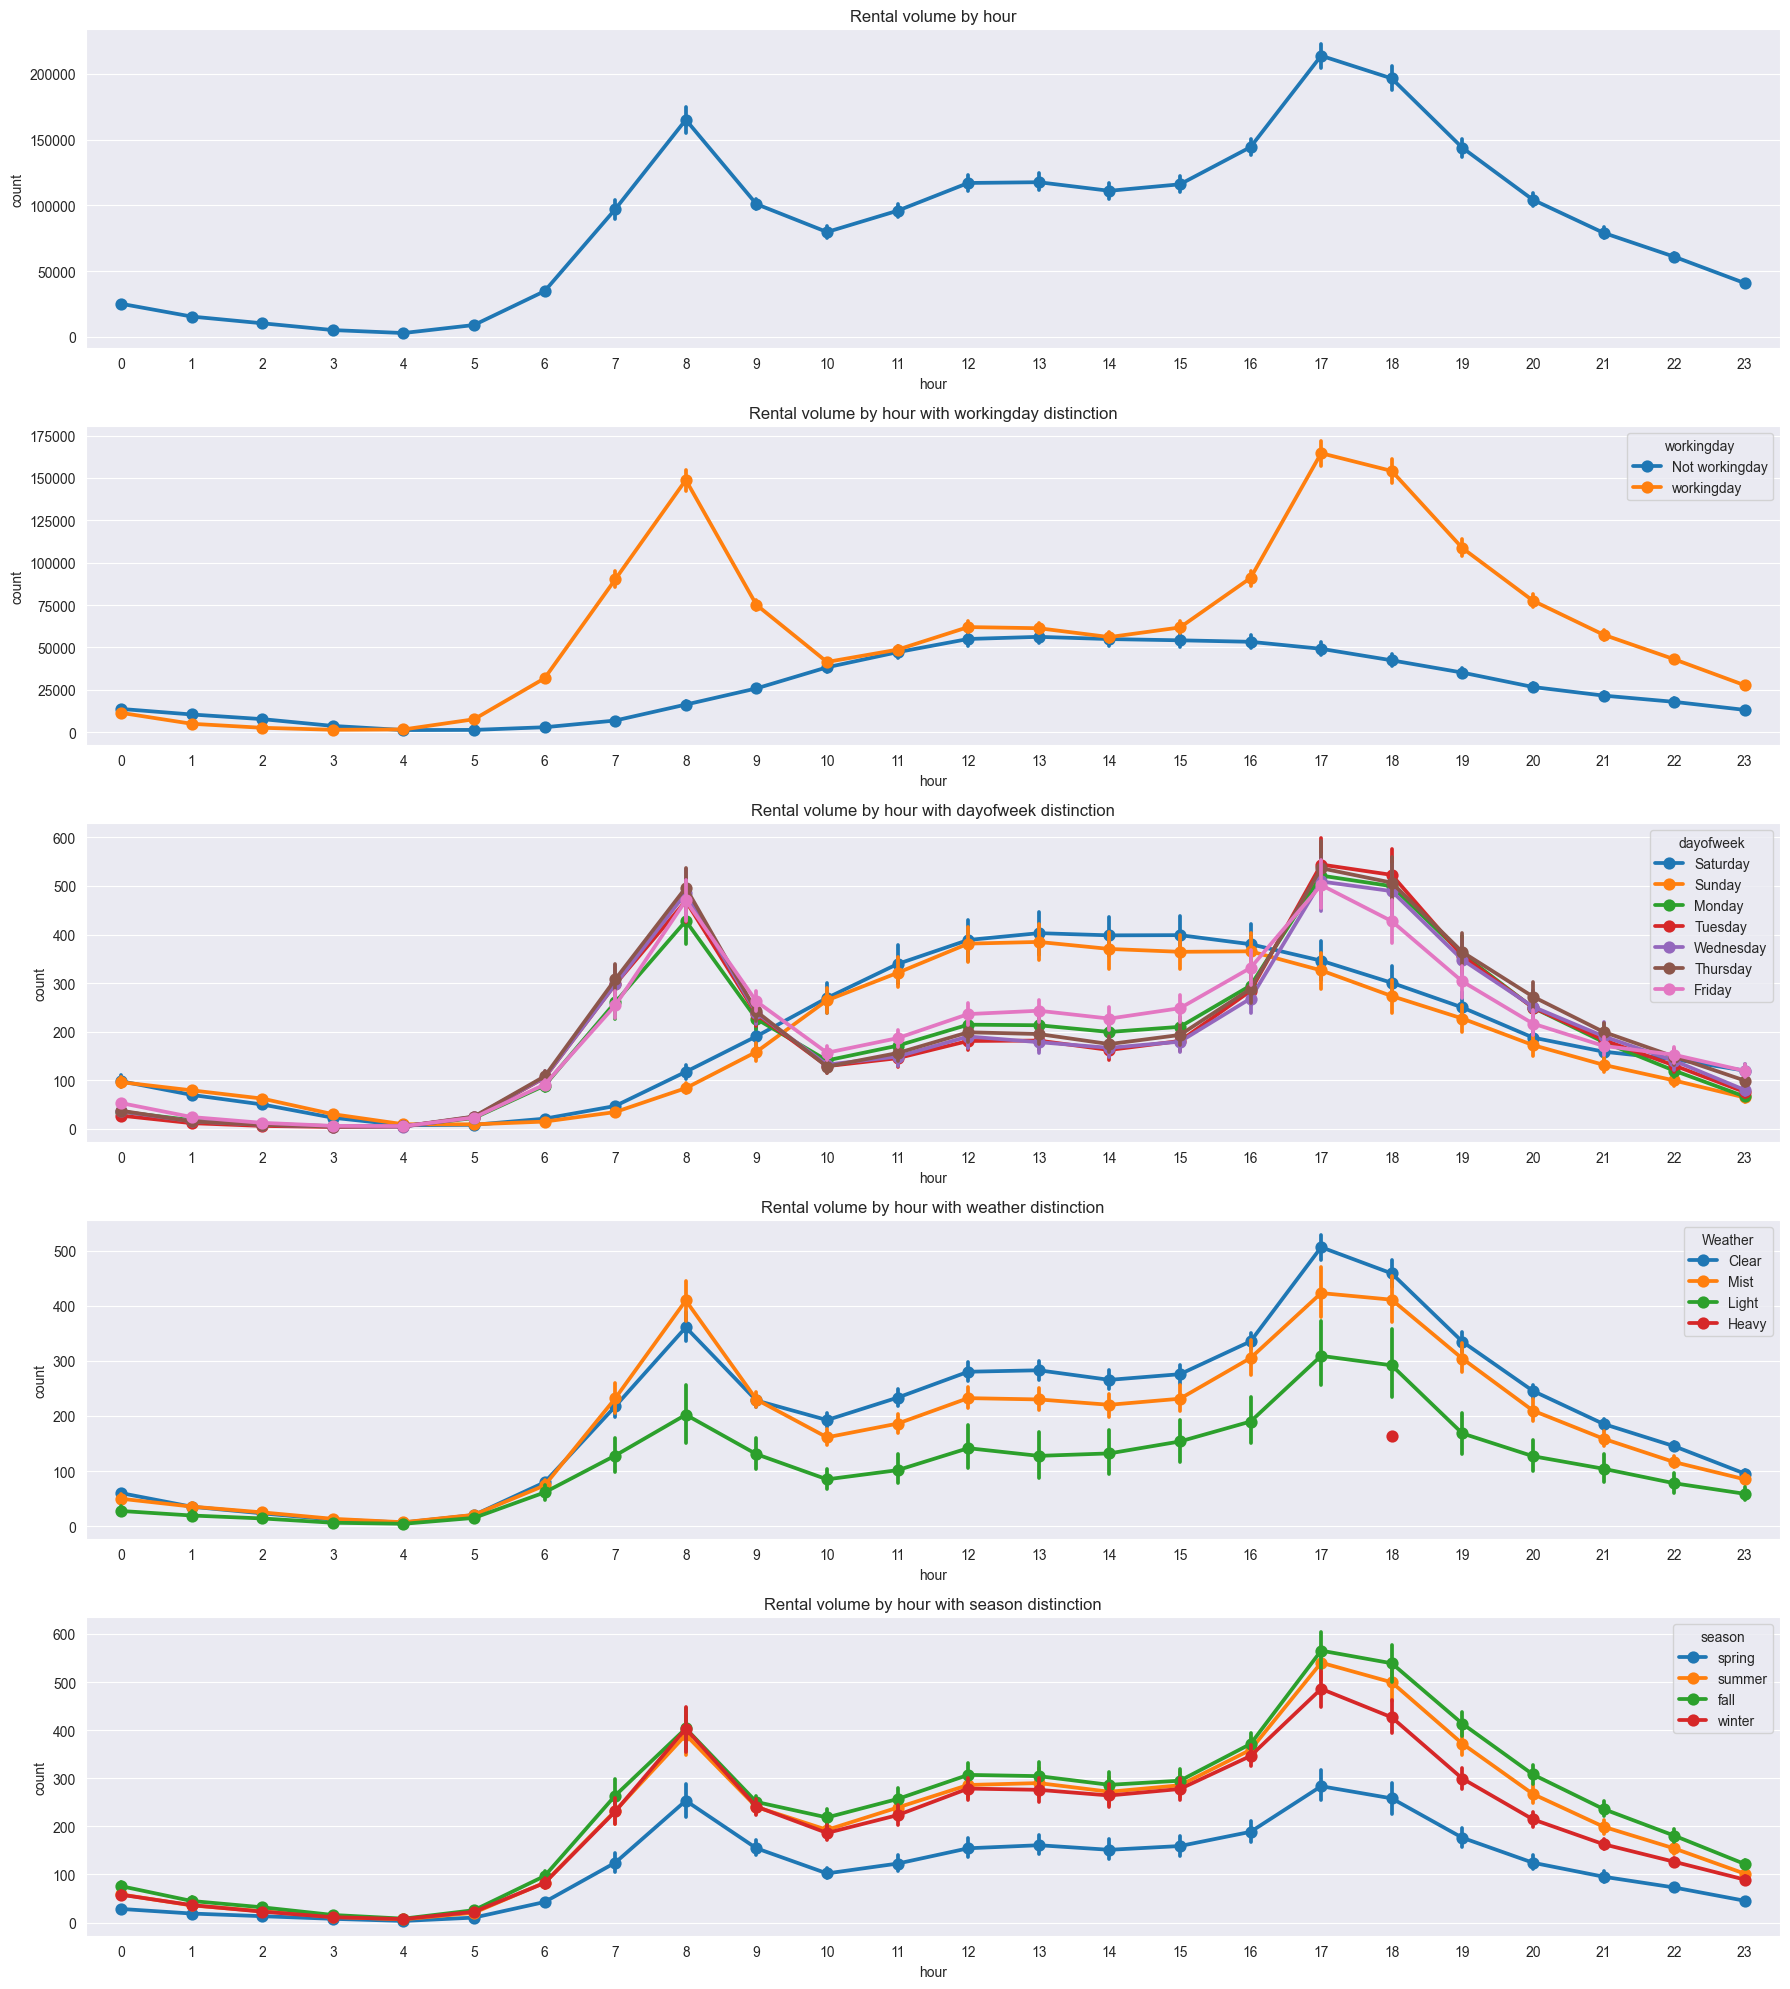

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18, 20)

sns.pointplot(data=df_eda, x="hour", y="count", estimator=sum, ax=ax1)
ax1.set_title("Rental volume by hour")
sns.pointplot(data=df_eda, x="hour", y="count", hue="workingday", estimator=sum, ax=ax2)
ax2.set_title("Rental volume by hour with workingday distinction")
sns.pointplot(data=df_eda, x="hour", y="count", hue="dayofweek", ax=ax3)
ax3.set_title("Rental volume by hour with dayofweek distinction")
sns.pointplot(data=df_eda, x="hour", y="count", hue="weather", ax=ax4)
ax4.set_title("Rental volume by hour with weather distinction")
sns.pointplot(data=df_eda, x="hour", y="count", hue="season", ax=ax5)
ax5.set_title("Rental volume by hour with season distinction")

handles, labels = ax4.get_legend_handles_labels()
labels = [label[:5] for label in labels]
ax4.legend(handles, labels, title="Weather")

plt.tight_layout()
plt.show()

- Furthermore, it's worth noting that the trend observed on non-working days, particularly Saturdays and Sundays, remains consistent, with high demand for bikes observed from 9 AM to 8 PM.
- Conversely, on working days (Monday to Friday), the demand follows a different pattern: there's a high demand from 7 AM to 9 AM and from 5 PM to 7 PM, an average demand from 10 AM to 4 PM, and a low demand from 12 AM to 6 AM and from 8 PM to 12 PM. However, further exploration is warranted to fully understand these usage patterns.
- Additionally, it's noteworthy that the weather and seasonal patterns align with the usage trends observed during the evening peak hours. On non-working days, particularly Saturdays and Sundays, high demand for bikes is consistently observed from 9 AM to 8 PM.
- Similarly, on working days (Monday to Friday), the demand follows a different pattern: there's a high demand from 7 AM to 9 AM and from 5 PM to 7 PM, an average demand from 10 AM to 4 PM, and a low demand from 12 AM to 6 AM and from 8 PM to 12 PM. However, further exploration is warranted to fully understand these usage patterns.

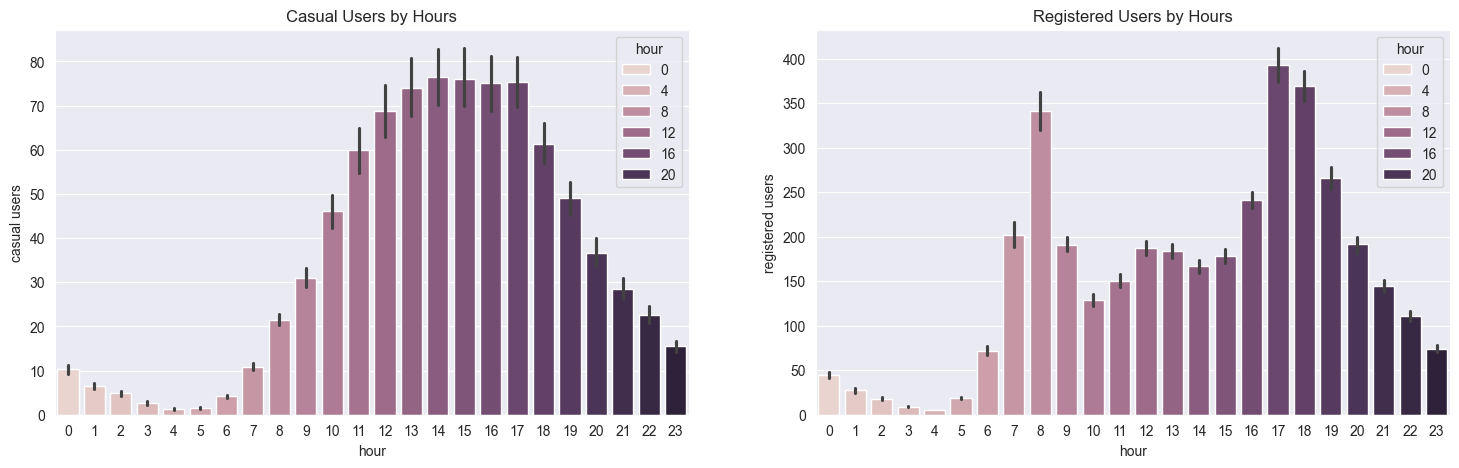

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18,5), sharex=False, sharey=False)

sns.barplot(x='hour', y='casual', hue='hour', data=df_eda, ax=axs[0])
axs[0].set_ylabel('casual users')
axs[0].set_title('Casual Users by Hours')

sns.barplot(x='hour', y='registered', hue='hour', data=df_eda, ax=axs[1])
axs[1].set_ylabel('registered users')
axs[1].set_title('Registered Users by Hours');

We have two user in this dataset: registered and casual users. There exists a pattern in the relationship between each user and the hour of the day. It's evident that the pattern for casual users resembles that of non-working days, particularly weekends, while registered users exhibit a pattern more similar to working days or weekdays. This suggests that casual users tend to utilize the service more during leisure hours, such as weekends, while registered users tend to use it more during typical commuting hours on weekdays.

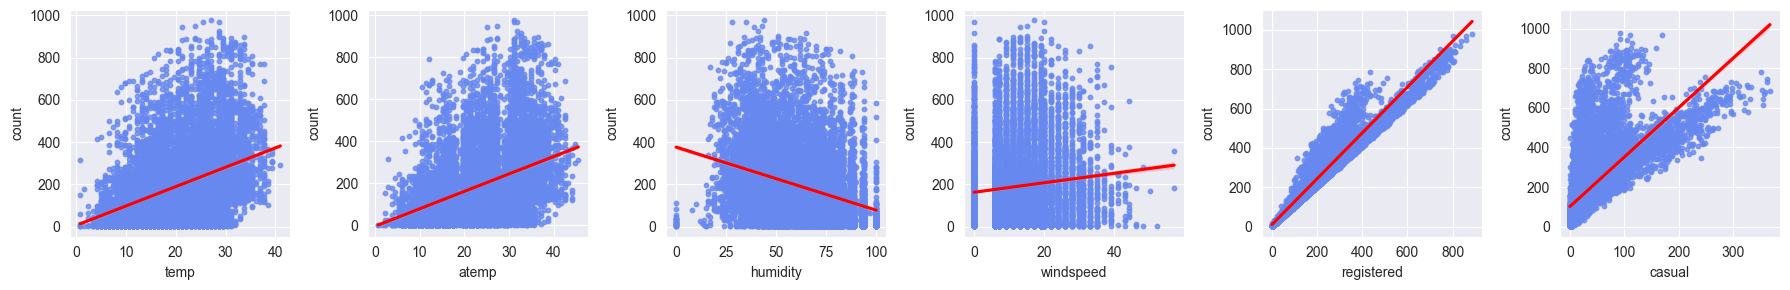

In [16]:
fields = ['temp', 'atemp', 'humidity', 'windspeed', 'registered', 'casual']
plt.figure(figsize=(18, 3))
sns.set_palette("coolwarm")

for i, f in enumerate(fields):
    plt.subplot(1, len(fields), i+1)
    sns.regplot(x=df[f], y=df['count'], scatter_kws={'s':10}, line_kws={'color':'red'})
    plt.ylabel('count')
    plt.xlabel(f)
    
plt.tight_layout()
plt.show()

We saw the correlation between numeric features and the rental count. In this instance, 'temp' and 'atemp' exhibit a higher correlation, albeit not very high, at 0.39. Additionally, 'humidity' shows a negative correlation of -0.32, while 'windspeed' only has a correlation coefficient of 0.10.

<Axes: >

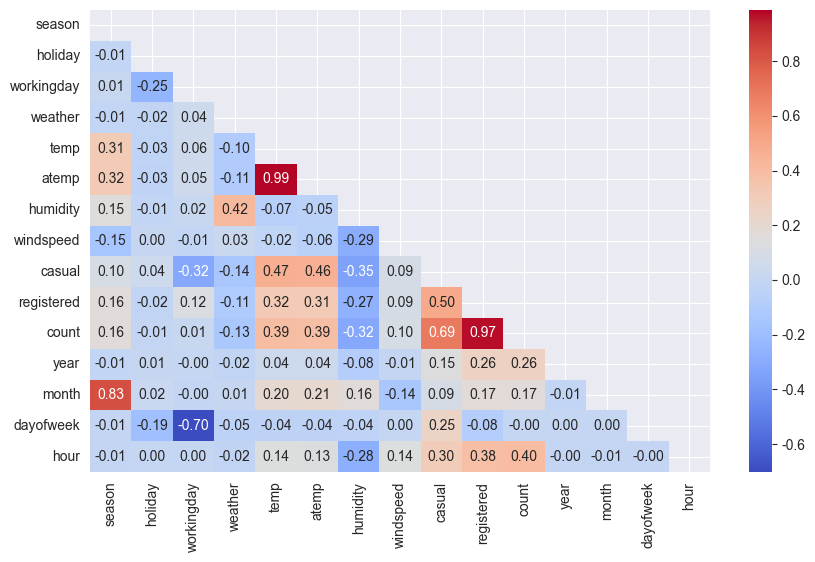

In [17]:
# heatmap correlation
plt.figure(figsize=(10, 6))

numeric_train = df.select_dtypes(include='number')
correlation = numeric_train.corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)

- Feels-like Temperature (atemp): Highly correlated with temp, suggesting a strong relationship between perceived and actual temperature.
- Temperature (temp): Positively correlated with the number of casual users, indicating more casual users prefer to bike when it's warmer.
- Windspeed: Has a lower correlation compared to temp and humidity, indicating it might have less impact on bike demand.

So, on heatmap we coclude:
- `Feels-like Temperature (atemp)` and `Temperature (temp)` exhibit a strong correlation (> 0.75) with bike rental demand. Therefore, atemp may be excluded from modeling to avoid redundancy.
- `Month` can be omitted to prevent redundancy with other temporal features like `Season` and `dayofweek`, enhancing model efficiency.
- `Casual` and `Registered` users may be removed due to redundancy with the total count of rentals, simplifying model complexity.

## Data Preprocessing

In [18]:
df1 = df.copy()
df1.shape

(17379, 17)

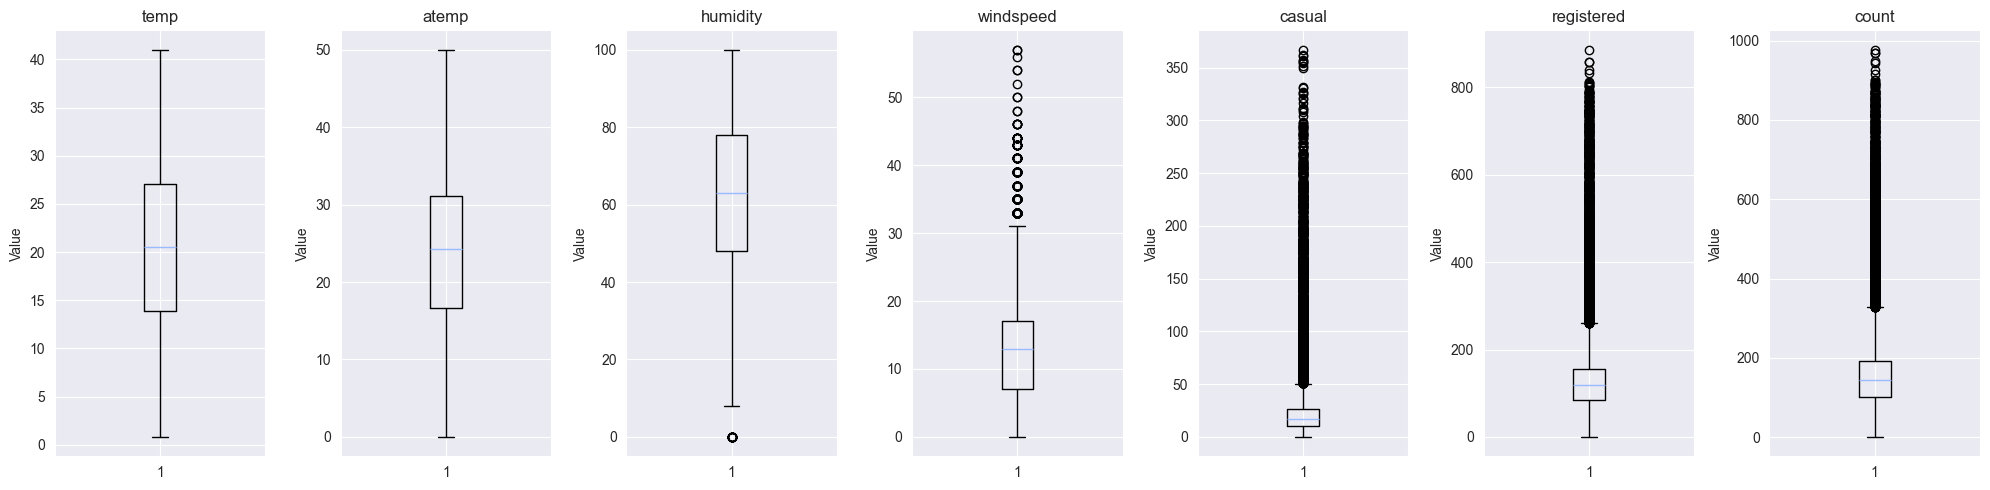

In [19]:
fields = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
num_fields = len(fields)
fig, axes = plt.subplots(1, num_fields, figsize=(20, 5))  # Adjusted figsize for better spacing

df1_filled = df1[fields].fillna(df1[fields].median())

for i, field in enumerate(fields):
    axes[i].boxplot(df1_filled[field])
    axes[i].set_title(field)
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()


We also examined outliers in each numeric feature, particularly noting outliers in `windspeed`, `humidity`, `casual`, `registered`, and `count`. While these outliers are natural occurrences and not errors, many outliers are present in the counts of registered and casual users. These might indicate groups of non-registered users. To address these outliers, we will apply a logarithmic transformation and re-examine the plots to assess the effect of this transformation.



In [20]:
cats_features = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for f in cats_features:
    df1[f] = df1[f].astype("category")

SPLIT DATA

In [21]:
train = df1[pd.notnull(df1['count'])]
test = df1[~pd.notnull(df1['count'])]
y_train = train['count']

In [22]:
drop_features = ['count', 'casual', 'registered', 'atemp', 'datetime', 'month', 'year','year_month']

X_train = train.drop(drop_features, axis=1)
X_test = test.drop(drop_features, axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   humidity    10886 non-null  int64   
 6   windspeed   10886 non-null  float64 
 7   dayofweek   10886 non-null  category
 8   hour        10886 non-null  category
dtypes: category(6), float64(2), int64(1)
memory usage: 405.4 KB


### Modelling

RMSLE Metrics Evaluation

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y_train+1) for y_train in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y_train+1) for y_train in y_pred]))
    
    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

#### Default Model

In [24]:
# kNN model before tuning
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

knn_model = KNeighborsRegressor()

log_y = np.log1p(y_train)
knn_model.fit(X_train, log_y)

%time knn_preds = knn_model.predict(X_train)
rmsle_train_knn = rmsle(log_y, knn_preds, convertExp=False)
print('KNN RMSLE (Before Tuning on Training Data):', round(rmsle_train_knn, 5))

# Define RMSLE scorer for cross-validation
rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=False)
scores_knn = cross_val_score(knn_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('KNN RMSLE (Before Tuning on Cross-Validation):', round(-scores_knn.mean(), 5))

CPU times: total: 203 ms
Wall time: 251 ms
KNN RMSLE (Before Tuning on Training Data): 0.13321
KNN RMSLE (Before Tuning on Cross-Validation): 0.19214


In [25]:
# Decision Tree model before tuning
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)

log_y = np.log1p(y_train)
dt_model.fit(X_train, log_y)

%time dt_preds = dt_model.predict(X_train)
rmsle_train_dt = rmsle(log_y, dt_preds, convertExp=False)
print('Decision Tree RMSLE (Before Tuning on Training Data):', round(rmsle_train_dt, 5))

# Define RMSLE scorer for cross-validation
rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=False)
scores_dt = cross_val_score(dt_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Decision Tree RMSLE (Before Tuning on Cross-Validation):', round(-scores_dt.mean(), 5))

CPU times: total: 15.6 ms
Wall time: 16.3 ms
Decision Tree RMSLE (Before Tuning on Training Data): 0.00531
Decision Tree RMSLE (Before Tuning on Cross-Validation): 0.14725


In [26]:
# Random Forest model before tuning
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

log_y = np.log1p(y_train)
rf_model.fit(X_train, log_y)

%time rf_preds = rf_model.predict(X_train)
rmsle_train_rf = rmsle(log_y, rf_preds, convertExp=False)
print('Random Forest RMSLE (Before Tuning on Training Data):', round(rmsle_train_rf, 5))

# Define RMSLE scorer for cross-validation
rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=False)
scores_rf = cross_val_score(rf_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Random Forest RMSLE (Before Tuning on Cross-Validation):', round(-scores_rf.mean(), 5))

CPU times: total: 62.5 ms
Wall time: 435 ms
Random Forest RMSLE (Before Tuning on Training Data): 0.03645
Random Forest RMSLE (Before Tuning on Cross-Validation): 0.12158


In [27]:
# Gradient Boosting model before tuning
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)

log_y = np.log1p(y_train)
gb_model.fit(X_train, log_y)

%time gb_preds = gb_model.predict(X_train)
rmsle_train_gb = rmsle(log_y, gb_preds, convertExp=False)
print('Gradient Boosting RMSLE (Before Tuning on Training Data):', round(rmsle_train_gb, 5))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False, convertExp=False)
scores_gb = cross_val_score(gb_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Gradient Boosting RMSLE (Before Tuning on Cross-Validation):', round(-scores_gb.mean(), 5))

CPU times: total: 0 ns
Wall time: 27 ms
Gradient Boosting RMSLE (Before Tuning on Training Data): 0.09976
Gradient Boosting RMSLE (Before Tuning on Cross-Validation): 0.12394


#### Hyperparameter Tuning

We decided to tuning all the models to get better RMSLE scores.

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_params = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
random_search_knn_model = RandomizedSearchCV(estimator=knn_model,
                                             param_distributions=knn_params,
                                             n_iter=100,
                                             scoring=rmsle_scorer,
                                             cv=5,
                                             random_state=42)
log_y = np.log1p(y_train)
%time random_search_knn_model.fit(X_train, log_y)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
best_knn_model = random_search_knn_model.best_estimator_
print('Best Parameters:', random_search_knn_model.best_params_)

knn_best_preds = best_knn_model.predict(X_train)
print('KNN RMSLE:', round(rmsle(log_y, knn_best_preds, convertExp=True), 5))

scores_knn_model = cross_val_score(best_knn_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Cross-Validation KNN RMSLE:', round(-scores_knn_model.mean(), 5))

CPU times: total: 32.8 s
Wall time: 1min
Best Parameters: {'weights': 'distance', 'n_neighbors': 7, 'algorithm': 'auto'}
KNN RMSLE: 0.01804
Cross-Validation KNN RMSLE: 0.79392


In [29]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': list(range(1, 20, 2)),
    'min_samples_split': list(range(1, 20, 2)), 
    'min_samples_leaf': list(range(1, 20, 2))
}
random_search_dt_model = RandomizedSearchCV(estimator=dt_model,
                                            param_distributions=dt_params,
                                            n_iter=100, 
                                            scoring=rmsle,
                                            cv=5, 
                                            random_state=42,
                                            n_jobs=-1)

log_y = np.log1p(y_train)
%time random_search_dt_model.fit(X_train, log_y)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
best_dt_model = random_search_dt_model.best_estimator_
print('Best Parameters:', random_search_dt_model.best_params_)

dt_best_preds = best_dt_model.predict(X_train)
print('Decision Tree RMSLE:', round(rmsle(log_y, dt_best_preds, convertExp=True), 5))

scores_dt_model = cross_val_score(best_dt_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Cross-Validation Decistion Tree RMSLE:', round(-scores_dt_model.mean(), 5))

CPU times: total: 609 ms
Wall time: 8.89 s
Best Parameters: {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 11}
Decision Tree RMSLE: 0.34117
Cross-Validation Decistion Tree RMSLE: 0.58205


In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': list(range(1, 200, 5)),
    'max_depth':list(range(1, 20, 2)),
    'min_samples_split': list(range(1, 20, 2)),
    'min_samples_leaf': list(range(1, 20, 2))
}
random_search_rf_model = RandomizedSearchCV(estimator=rf_model,
                                            param_distributions=rf_params,
                                            n_iter=100,  
                                            scoring= rmsle, 
                                            cv=5,
                                            random_state=42,
                                            n_jobs=-1)
log_y = np.log1p(y_train)
%time random_search_rf_model.fit(X_train, log_y)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
best_rf_model = random_search_rf_model.best_estimator_
print('Best Parameters:', random_search_rf_model.best_params_)

rf_best_preds = best_rf_model.predict(X_train)
print('Random Forest RMSLE:', round(rmsle(log_y, rf_best_preds, convertExp=True), 5))

scores_rf_model = cross_val_score(best_rf_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Cross-Validation Random Forest RMSLE:', round(-scores_rf_model.mean(), 5))

CPU times: total: 6.25 s
Wall time: 7min 4s
Best Parameters: {'n_estimators': 176, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_depth': 7}
Random Forest RMSLE: 0.44429
Cross-Validation Random Forest RMSLE: 0.60559


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': list(range(1, 20, 2)),
    'min_samples_split': list(range(1, 20, 2)),
    'min_samples_leaf': list(range(1, 20, 2))
}
random_search_gb_model = RandomizedSearchCV(estimator=gb_model,
                                            param_distributions=gb_params,
                                            n_iter=100,  
                                            scoring=rmsle,
                                            cv=5,
                                            random_state=42,
                                            n_jobs=-1)
log_y = np.log1p(y_train)
%time random_search_gb_model.fit(X_train, log_y)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
best_gb_model = random_search_gb_model.best_estimator_
print('Best Parameters:', random_search_gb_model.best_params_)

gb_best_preds = best_gb_model.predict(X_train)
print('Gradient Boosting RMSLE:', round(rmsle(log_y, gb_best_preds, convertExp=True), 5))

scores_gb_model = cross_val_score(best_gb_model, X_train, log_y, cv=5, scoring=rmsle_scorer)
print('Cross-Validation Gradient Boosting RMSLE:', round(-scores_gb_model.mean(), 5))

CPU times: total: 4.95 s
Wall time: 10min 8s
Best Parameters: {'n_estimators': 191, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_depth': 1, 'learning_rate': 0.2}
Gradient Boosting RMSLE: 0.60705
Cross-Validation Gradient Boosting RMSLE: 0.70698


#### Chose the Best of Model

The best model in our analysis was determined based on its performance in minimizing the Root Mean Squared Logarithmic Error (RMSLE). RMSLE was chosen as the primary evaluation metric because it provides a robust measure of predictive accuracy, particularly when dealing with skewed target variables and a wide range of predicted values. Lower RMSLE values indicate better model performance in capturing the relative differences between actual and predicted values on a logarithmic scale.


`Among the models, Random Forest algorithm before tuning demonstrated the lowest RMSLE and low indicates to overfitting compared to other models.` This means that the model was most effective at capturing the underlying patterns and relationships in the data, resulting in more accurate predictions compared to other models.

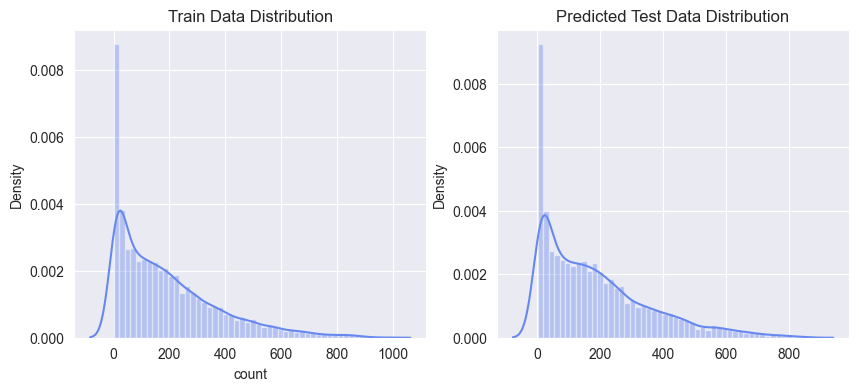

In [32]:
figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.distplot(y_train, ax=axes[0], bins=50)
axes[0].set_title('Train Data Distribution')
sns.distplot(np.exp(rf_preds), ax=axes[1], bins=50)
axes[1].set_title('Predicted Test Data Distribution');

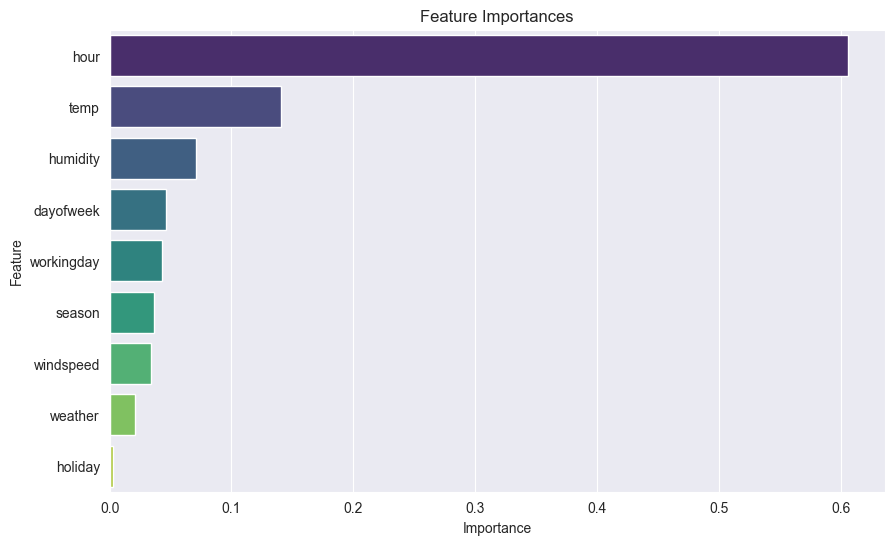

In [47]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [34]:
rf_model = RandomForestRegressor(random_state=42)
log_y = np.log1p(y_train)
rf_model.fit(X_train, log_y)

# Make predictions on the test data
log_rf_preds = rf_model.predict(X_test)
rf_preds = np.expm1(log_rf_preds)

rounded_rf_preds = [round(pred) for pred in rf_preds]

if len(rounded_rf_preds) == len(submission):
    submission['count'] = rounded_rf_preds
    submission.to_csv('submission_with_rf.csv', index=False)
else:
    raise ValueError(f"Length of predictions ({len(rounded_rf_preds)}) does not match length of submission DataFrame ({len(submission)})")

In [35]:
submission["count"]
print(submission.shape)
submission.head(24)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,4
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,3
5,2011-01-20 05:00:00,16
6,2011-01-20 06:00:00,57
7,2011-01-20 07:00:00,153
8,2011-01-20 08:00:00,295
9,2011-01-20 09:00:00,176


In [36]:
result = df_test.copy()
result['count'] = rounded_rf_preds
result.head(24)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,14
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,5
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,4
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,16
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,57
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,153
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,295
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,176


In [48]:
submission.to_csv("bike-rental-demand", index=False)